# Import Libraries

In [46]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import keras
from keras import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

# 10.1 Load Base Model and Add New Layers



In [47]:
# 1. Load base model
base_model = MobileNet(weights='imagenet', include_top=False)


# 2. Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(3, activation="softmax")(x)


# 3. Assign transfer base model + new layers to model
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

In [48]:
# 4. Assign Trainable layers and freeze layer 
for layer in model.layers[:40]:
  layer.trainable = False

for layer in model.layers[40:]:
  layer.trainable = True

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

### Compare layer tarinable

Before assign:
```
Total params: 5,854,403
Trainable params: 5,832,515
Non-trainable params: 21,888
```

Assign with layer: 20
```
Total params: 5,854,403
Trainable params: 5,818,499
Non-trainable params: 35,904
```

Assign with layer: 30
```
Total params: 5,854,403
Trainable params: 5,767,171
Non-trainable params: 87,232
```

Assign with layer: 40
```
Total params: 5,854,403
Trainable params: 5,695,491
Non-trainable params: 158,912
```

---

# 10.2 Model Training and Validation

## 10.2.1 Create ImageDataGenerator (Train, Validation)

In [49]:
# 1. Create DataGenerator Object
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             zoom_range=0.5,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode="nearest")


# 2. Create Train Image generator
train_generator = datagen.flow_from_directory('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Cat_Dog_Horse',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=32,
                                              class_mode='categorical',
                                              seed=3,
                                              shuffle=True)


# 3. Create Validation Image generator
val_generator = datagen.flow_from_directory('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Cat_Dog_Horse',
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            batch_size=32,
                                            class_mode='categorical',
                                            seed=2,
                                            shuffle=True)

Found 222 images belonging to 3 classes.
Found 222 images belonging to 3 classes.


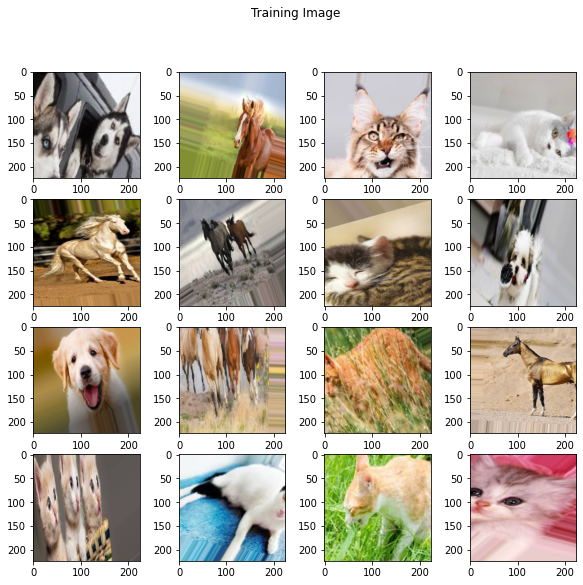

In [50]:
# View Training Images
fig = plt.figure(figsize=(10, 9))
fig.suptitle("Training Image")
rows = 4
columns = 4

for i in range(16):
  batch = train_generator.next()
  img_train = (batch[0])

  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img_train[i])
plt.show()

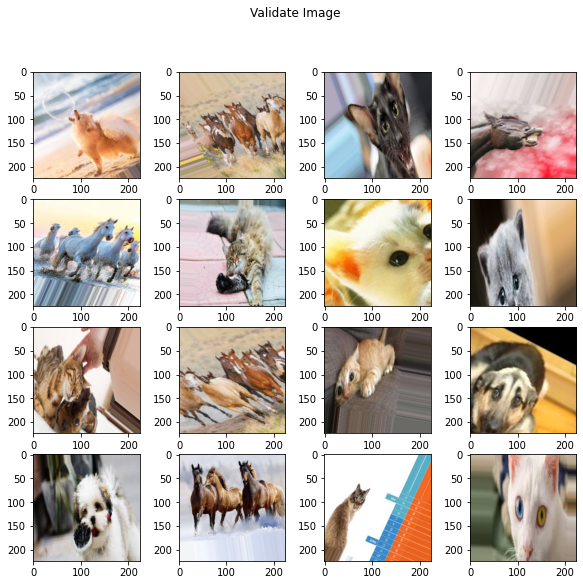

In [51]:
# View Validation Images
fig = plt.figure(figsize=(10, 9))
fig.suptitle("Validate Image")
rows = 4
columns = 4

for i in range(16):
  batch = val_generator.next()
  img_val = (batch[0])

  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img_val[i])
plt.show()

## 10.2.2 Create Optimizer, parameters

In [52]:
# 4. Create Optimizer
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 5. Define training Generator Parameter
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size

print("step_size_train:", step_size_train)
print("step_size_val:", step_size_val)

step_size_train: 6
step_size_val: 6


## 10.2.3 Training Validation, Plot accuracy, loss

In [53]:
# 6. Training
history = model.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=val_generator,
                    validation_steps=step_size_val,
                    epochs=16,
                    verbose=1)

Epoch 1/16
6/6 [==============================] - 12s 2s/step - loss: 1.4927 - accuracy: 0.6263 - val_loss: 1.1315 - val_accuracy: 0.7760
Epoch 2/16
6/6 [==============================] - 7s 1s/step - loss: 0.7603 - accuracy: 0.7760 - val_loss: 0.5635 - val_accuracy: 0.8125
Epoch 3/16
6/6 [==============================] - 8s 1s/step - loss: 0.6246 - accuracy: 0.7947 - val_loss: 0.9502 - val_accuracy: 0.7812
Epoch 4/16
6/6 [==============================] - 7s 1s/step - loss: 0.5290 - accuracy: 0.7947 - val_loss: 0.8758 - val_accuracy: 0.8125
Epoch 5/16
6/6 [==============================] - 7s 1s/step - loss: 0.4641 - accuracy: 0.8421 - val_loss: 1.3026 - val_accuracy: 0.6354
Epoch 6/16
6/6 [==============================] - 7s 1s/step - loss: 0.4392 - accuracy: 0.8211 - val_loss: 1.8673 - val_accuracy: 0.4792
Epoch 7/16
6/6 [==============================] - 7s 1s/step - loss: 0.4346 - accuracy: 0.8526 - val_loss: 0.7885 - val_accuracy: 0.7344
Epoch 8/16
6/6 [========================

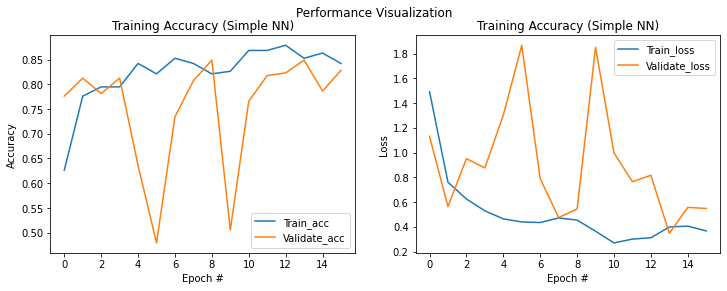

In [54]:
# 7. Performance Visualization
fig = plt.figure(figsize=(12, 4))
fig.suptitle("Performance Visualization")
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.plot(history.history["accuracy"], label='Train_acc')
plt.plot(history.history["val_accuracy"], label='Validate_acc')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title("Training Accuracy (Simple NN)")
plt.legend()

fig.add_subplot(rows, columns, 2)
plt.plot(history.history["loss"], label='Train_loss')
plt.plot(history.history["val_loss"], label='Validate_loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title("Training Accuracy (Simple NN)")
plt.legend()

plt.show()

---

# 10.3 Model Testing and Performance Visualize

## 10.3.1 Create ImageDataGenerator (Test) and Predict Results

In [55]:
# 1. Initial test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Cat_Dog_Horse',
                                                  class_mode="categorical",
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  shuffle="False",
                                                  seed=42,
                                                  batch_size=1)


# 2. Get class id for y_real_class
y_true = test_generator.classes


# 3. Predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
for i in range(len(y_true)):
  img_test = test_generator.next()
  pred = model.predict(img_test[0], verbose=0)
  pred_prob.append(np.array(pred[0]))

Found 222 images belonging to 3 classes.


In [56]:
# 4. Get class id from max prob
df_pred = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)

# 5. Calculate confusion matrix, classfication report between y_true and df_class
print(confusion_matrix(y_true, df_class))
print(classification_report(y_true, df_class))

[[  2  14   0]
 [ 18 157   0]
 [  5  26   0]]
              precision    recall  f1-score   support

           0       0.08      0.12      0.10        16
           1       0.80      0.90      0.84       175
           2       0.00      0.00      0.00        31

    accuracy                           0.72       222
   macro avg       0.29      0.34      0.31       222
weighted avg       0.63      0.72      0.67       222



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
